## 第一步 引入需要的库

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression  #线性回归
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn import metrics

#作图分析
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

%matplotlib inline
import seaborn as sns
sns.set(font_scale=1.8)
sns.set_style("darkgrid",{"font.sans-serif":['simhei','Droid Sans Fallback']})

## 第二步 已知信息汇总

### 变量赋值

- 固定成本

In [2]:
# 头程费用
head_process_cost=6000
# 购买成本 20元/个* 3000个
buy_cost=20*3000
# 广告花费，由于目的是促销，我们就不再投入广告费用
ad_cost=0
# 总的固定费用
fixcost=ad_cost+buy_cost+head_process_cost

- 其它不变量的信息

In [3]:
# 待处理的产品库存
item_count=3000
# 原始单价（美金）
price_origin=27.5
# 初始时reviews
reviews=100

- 单位成本，这里的单位，包括了时间、销售量

In [4]:
# 可变成本的单位库存（销量）成本 （美金）
# 单位库存的FBA存储费用（平均）
store_cost_per=0.5*7
# 单位库存的FBA超长库存成本
store_cost_long_per=0.28*7
# 单位销量FBA配送费用
fba_fullfil_cost_per=20
# 其它各类成本(每卖掉一单位的产品平摊的潜在的退换损失费用)
fba_other=0.5*7
# 单位销量的FBA佣金
amz_fee_per=0.15

- *价格（策略）* 将从15美金-60美金分出90个等间值，看哪个单价能够获得最高的收益

`np.linspace(start, stop, num)`构造一个等差数列,返回的是 [start, stop]之间的均匀分布

In [7]:
price_list=np.linspace(15,60,90).round(1)
print(price_list)

[15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.6 20.1 20.6 21.1 21.6
 22.1 22.6 23.1 23.6 24.1 24.6 25.1 25.6 26.1 26.6 27.1 27.6 28.1 28.7
 29.2 29.7 30.2 30.7 31.2 31.7 32.2 32.7 33.2 33.7 34.2 34.7 35.2 35.7
 36.2 36.7 37.2 37.8 38.3 38.8 39.3 39.8 40.3 40.8 41.3 41.8 42.3 42.8
 43.3 43.8 44.3 44.8 45.3 45.8 46.3 46.9 47.4 47.9 48.4 48.9 49.4 49.9
 50.4 50.9 51.4 51.9 52.4 52.9 53.4 53.9 54.4 54.9 55.4 56.  56.5 57.
 57.5 58.  58.5 59.  59.5 60. ]


- 不同价格下，我们把固定成本和相关的变量放到一起

In [8]:
# 假定已经达到长期库存的条件，
# 与库存相关的变动成本
store_cost_per=[store_cost_per+store_cost_long_per for _ in range(len(price_list))] 
# 与销售情况相关的变动成本
cost_v=[fba_fullfil_cost_per+amz_fee_per*i*7+fba_other for i in price_list]

# 初始评论数量
reviews_o=[reviews for _ in range(len(price_list))] 

# 组成datafram格式，便于我们进行处理
X_pred=pd.DataFrame(list(zip(price_list,reviews_o,cost_v,store_cost_per)),columns=['price','reviews','cost_v','store_cost_per'])
X_pred.head()

,price,reviews,cost_v,store_cost_per
0,15.0,100,39.250,5.46
1,15.5,100,39.775,5.46
2,16.0,100,40.300,5.46
3,16.5,100,40.825,5.46
4,17.0,100,41.350,5.46


## 第三步，根据市场情况，计算随不同定价下的收益-成本值

用多元线性回归模型

其中因变量是销量y-->训练数据是来自大类排名得到的月估计销量

自变量是price、reviews

训练的数据是定时抓取的热销榜的数据/如果自有数据充足，也可以用自己的数据来建模，效果更好

### 数据导入

In [10]:
# 数据导入
data=pd.read_excel('lesson3.xlsx')
data.head()

,price,reviews,rank,sale_est,id
0,22.490,366.0,8,2103.0,1
1,39.095,1214.1,26,1515.0,1
2,30.470,845.9,35,1371.0,1
3,18.460,344.0,58,1137.0,1
4,20.490,217.3,84,975.0,1


In [11]:
data.isnull().any()

price       False
reviews     False
rank        False
sale_est    False
id          False
dtype: bool

In [12]:
data.describe()

,price,reviews,rank,sale_est,id
count,96.000000,96.000000,96.000000,96.000000,96.0
mean,23.964375,266.819792,1049.791667,273.822917,1.0
std,12.316103,254.841991,794.460014,376.456031,0.0
min,8.990000,4.600000,8.000000,11.100000,1.0
25%,16.990000,77.975000,306.500000,30.600000,1.0
50%,20.720000,201.350000,967.500000,122.250000,1.0
75%,25.068750,345.125000,1778.250000,340.500000,1.0
max,64.970000,1214.100000,2610.000000,2103.000000,1.0


### 模型建立

In [13]:
# 提取出自变量和因变量
X=data.loc[:,['reviews','price']]
y=data['sale_est']

# 拆分训练集和预测集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# 用LinerRegression来实现
lr = LinearRegression()
lr.fit(X_train, y_train)

print('参数分别为：',lr.coef_)
print('截距项为：',lr.intercept_)

y_hat = lr.predict(X_test)

MSE = metrics.mean_squared_error(y_test, y_hat)
RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_hat))

print('MSE:',MSE)
print('RMSE:',RMSE)

参数分别为： [ 0.52144924 -4.72830737]
截距项为： 260.78587790914185
MSE: 71174.74414738538
RMSE: 266.78595193035443


得到的销量计算公式
$$ Y_(sales) = 260.92 + 0.52*X_(reviews) - 4.73*X_(price) $$

与我们的预期一致，价格越低，reviews越多，销量越好

In [14]:
# 销量预测
y_pred = lr.predict(X_pred[['reviews','price']])
X_pred['sales_est']=y_pred
X_pred.head()

,price,reviews,cost_v,store_cost_per,sales_est
0,15.0,100,39.250,5.46,242.006191
1,15.5,100,39.775,5.46,239.642037
2,16.0,100,40.300,5.46,237.277884
3,16.5,100,40.825,5.46,234.913730
4,17.0,100,41.350,5.46,232.549576


### 售完所需月份数估计

通过月份数的计算，可以确定最终需要的库存费用/超长库存费用

- case1: reviews不变的话，可以看到，每个月销量将是固定的

利润率 = 销售额 - 成本
销售额=单价（15-60美金的区间取值） * 销量（3000）
成本=固定成本+变动成本（单价有关*佣金+库存（3000-销量）* 月份 *库存费用+销售*配送）

In [15]:
X_pred['sell_out_month_1']=(item_count/X_pred['sales_est']).round(0)+1
X_pred

,price,reviews,cost_v,store_cost_per,sales_est,sell_out_month_1
0,15.0,100,39.250,5.46,242.006191,13.0
1,15.5,100,39.775,5.46,239.642037,14.0
2,16.0,100,40.300,5.46,237.277884,14.0
3,16.5,100,40.825,5.46,234.913730,14.0
4,17.0,100,41.350,5.46,232.549576,14.0
...,...,...,...,...,...,...
85,58.0,100,84.400,5.46,38.688974,79.0
86,58.5,100,84.925,5.46,36.324821,84.0
87,59.0,100,85.450,5.46,33.960667,89.0
88,59.5,100,85.975,5.46,31.596513,96.0


- case2: reviews随销量的累计而每月有6%的自然留评，那么销量是逐渐递增的

In [16]:
# 直到售罄
def get_sell_out_month(df):
    # 第一个月，用的是当前的price和reviews
    sell_out_n=1
    m=item_count # 原始的数量
    reviews=df['reviews'][0]
    price=df['price'][0]
    # 第一个月的销量预估
    sales_est=lr.predict([[reviews,price]])[0].round(0)
    # 从第二个月开始
    sales_est_list=[]
    while m//sales_est>0:       
        # 还剩下多少个
        m=m-sales_est
        # reviews变成了多少
        reviews=reviews+sales_est*0.06
        # 当月卖了多少个
        sales_est=lr.predict([[reviews,price]])[0].round(0)
        sell_out_n+=1
        sales_est_list.append(sales_est)
        #print(m,sales_est,reviews)
    # 最后一个月剩下的卖完
    sales_est_list.append(m)
    sell_out_n=sell_out_n+1
    return sell_out_n,sales_est_list

# 月份、销量、reviews取整

In [17]:
# 亚马逊仓储相关计算
# 以售完为终止
X_pred['id']=range(len(X_pred['reviews']))
X_pred['sell_out_month_2']=X_pred.groupby('id').apply(get_sell_out_month)
p=X_pred['sell_out_month_2'].apply(pd.Series)
p.columns=['sell_out_month_2','sales_est_list']

X_pred=pd.concat([X_pred.drop('sell_out_month_2',axis=1),p],axis=1)
X_pred

,price,reviews,cost_v,store_cost_per,sales_est,sell_out_month_1,id,sell_out_month_2,sales_est_list
0,15.0,100,39.250,5.46,242.006191,13.0,0,12,"[250.0, 257.0, 265.0, 274.0, 282.0, 291.0, 300..."
1,15.5,100,39.775,5.46,239.642037,14.0,1,12,"[247.0, 255.0, 263.0, 271.0, 280.0, 288.0, 297..."
2,16.0,100,40.300,5.46,237.277884,14.0,2,12,"[245.0, 252.0, 260.0, 268.0, 277.0, 285.0, 294..."
3,16.5,100,40.825,5.46,234.913730,14.0,3,12,"[242.0, 250.0, 258.0, 266.0, 274.0, 283.0, 291..."
4,17.0,100,41.350,5.46,232.549576,14.0,4,13,"[240.0, 247.0, 255.0, 263.0, 271.0, 280.0, 289..."
...,...,...,...,...,...,...,...,...,...
85,58.0,100,84.400,5.46,38.688974,79.0,85,41,"[40.0, 41.0, 42.0, 44.0, 45.0, 47.0, 48.0, 50...."
86,58.5,100,84.925,5.46,36.324821,84.0,86,43,"[37.0, 39.0, 40.0, 41.0, 42.0, 44.0, 45.0, 46...."
87,59.0,100,85.450,5.46,33.960667,89.0,87,45,"[35.0, 36.0, 37.0, 38.0, 40.0, 41.0, 42.0, 43...."
88,59.5,100,85.975,5.46,31.596513,96.0,88,46,"[33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40...."


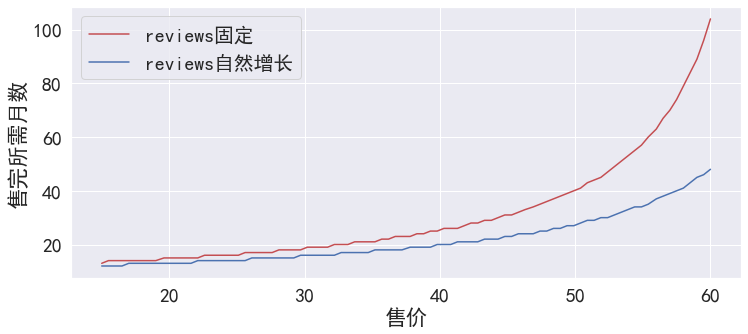

In [18]:
# 销量比对
fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(1,1,1)
l1,=ax.plot(X_pred['price'],X_pred['sell_out_month_1'],color='r',label='reviews固定')
l2,=ax.plot(X_pred['price'],X_pred['sell_out_month_2'],label='reviews自然增长')
plt.legend(handles=[l1,l2])
ax.set_xlabel('售价')
ax.set_ylabel('售完所需月数')
plt.show()

### 最终成本/利润率的计算

In [20]:
# 固定费用
X_pred['cost_fix']=fixcost
# 可变费用1 配送+佣金，但是销量是固定的
X_pred['cost_v_all']=X_pred['cost_v']*3000

In [22]:
# 可变费用2 仓储费
# sell_out_month，月初收取
def get_store_fee(df):
    # 月份，月初收费
    n=int(df['sell_out_month_2'][0])
    # 仓储费
    bill=df['store_cost_per'][0]
    # 头一个月算是全部的库存
    s=item_count*bill
    # 第二个月
    s1=(item_count-df['sales_est'][0])*bill+s
    # 第三个月开始
    for i in range(n-3):
        # 每个月产生了销量，就不再产生库存,第一个月卖了的，不计
        p=item_count-df['sales_est'][0]-sum(df['sales_est_list'][0][0:i+1])
        # 有库存产生仓储费
        s1+=p*bill
    return s1

X_pred['id']=X_pred.index
X_pred['cost_store']=X_pred.groupby('id').apply(get_store_fee)

In [23]:
X_pred['cost']=X_pred['cost_fix']+X_pred['cost_v_all']+X_pred['cost_store']
X_pred

,price,reviews,cost_v,store_cost_per,sales_est,sell_out_month_1,id,sell_out_month_2,sales_est_list,cost_fix,cost_v_all,cost_store,cost
0,15.0,100,39.250,5.46,242.006191,13.0,0,12,"[250.0, 257.0, 265.0, 274.0, 282.0, 291.0, 300...",66000,117750.0,100256.181963,284006.181963
1,15.5,100,39.775,5.46,239.642037,14.0,1,12,"[247.0, 255.0, 263.0, 271.0, 280.0, 288.0, 297...",66000,119325.0,101013.164754,286338.164754
2,16.0,100,40.300,5.46,237.277884,14.0,2,12,"[245.0, 252.0, 260.0, 268.0, 277.0, 285.0, 294...",66000,120900.0,101830.207545,288730.207545
3,16.5,100,40.825,5.46,234.913730,14.0,3,12,"[242.0, 250.0, 258.0, 266.0, 274.0, 283.0, 291...",66000,122475.0,102559.890337,291034.890337
4,17.0,100,41.350,5.46,232.549576,14.0,4,13,"[240.0, 247.0, 255.0, 263.0, 271.0, 280.0, 289...",66000,124050.0,103368.472440,293418.472440
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,58.0,100,84.400,5.46,38.688974,79.0,85,41,"[40.0, 41.0, 42.0, 44.0, 45.0, 47.0, 48.0, 50....",66000,253200.0,400912.129786,720112.129786
86,58.5,100,84.925,5.46,36.324821,84.0,86,43,"[37.0, 39.0, 40.0, 41.0, 42.0, 44.0, 45.0, 46....",66000,254775.0,418419.905629,739194.905629
87,59.0,100,85.450,5.46,33.960667,89.0,87,45,"[35.0, 36.0, 37.0, 38.0, 40.0, 41.0, 42.0, 43....",66000,256350.0,436290.534588,758640.534588
88,59.5,100,85.975,5.46,31.596513,96.0,88,46,"[33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40....",66000,257925.0,456214.413627,780139.413627


- 最终利润率确定，净利润按照毛利减30%来确定

In [25]:
# 销售额
X_pred['gmv']=X_pred['price']*7*3000
# 利润
X_pred['profit']=((X_pred['gmv']-X_pred['cost'])/X_pred['gmv']-0.3)

X_pred

,price,reviews,cost_v,store_cost_per,sales_est,sell_out_month_1,id,sell_out_month_2,sales_est_list,cost_fix,cost_v_all,cost_store,cost,gmv,profit
0,15.0,100,39.250,5.46,242.006191,13.0,0,12,"[250.0, 257.0, 265.0, 274.0, 282.0, 291.0, 300...",66000,117750.0,100256.181963,284006.181963,315000.0,-0.201607
1,15.5,100,39.775,5.46,239.642037,14.0,1,12,"[247.0, 255.0, 263.0, 271.0, 280.0, 288.0, 297...",66000,119325.0,101013.164754,286338.164754,325500.0,-0.179687
2,16.0,100,40.300,5.46,237.277884,14.0,2,12,"[245.0, 252.0, 260.0, 268.0, 277.0, 285.0, 294...",66000,120900.0,101830.207545,288730.207545,336000.0,-0.159316
3,16.5,100,40.825,5.46,234.913730,14.0,3,12,"[242.0, 250.0, 258.0, 266.0, 274.0, 283.0, 291...",66000,122475.0,102559.890337,291034.890337,346500.0,-0.139928
4,17.0,100,41.350,5.46,232.549576,14.0,4,13,"[240.0, 247.0, 255.0, 263.0, 271.0, 280.0, 289...",66000,124050.0,103368.472440,293418.472440,357000.0,-0.121900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,58.0,100,84.400,5.46,38.688974,79.0,85,41,"[40.0, 41.0, 42.0, 44.0, 45.0, 47.0, 48.0, 50....",66000,253200.0,400912.129786,720112.129786,1218000.0,0.108775
86,58.5,100,84.925,5.46,36.324821,84.0,86,43,"[37.0, 39.0, 40.0, 41.0, 42.0, 44.0, 45.0, 46....",66000,254775.0,418419.905629,739194.905629,1228500.0,0.098295
87,59.0,100,85.450,5.46,33.960667,89.0,87,45,"[35.0, 36.0, 37.0, 38.0, 40.0, 41.0, 42.0, 43....",66000,256350.0,436290.534588,758640.534588,1239000.0,0.087699
88,59.5,100,85.975,5.46,31.596513,96.0,88,46,"[33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40....",66000,257925.0,456214.413627,780139.413627,1249500.0,0.075639


## 第四步，可视化分析

matplotlib

In [26]:
#作图分析
# 主图坐标数据
x=X_pred['price']
y1=X_pred['profit']
y2=X_pred['sell_out_month_2']

# 特殊点
price_min=min(X_pred[X_pred['profit']>=0]['price'])
price_max=max(X_pred[X_pred['profit']>=0]['price'])
month_min=min(X_pred[X_pred['profit']>=0]['sell_out_month_2'])
month_max=max(X_pred[X_pred['profit']>=0]['sell_out_month_2'])

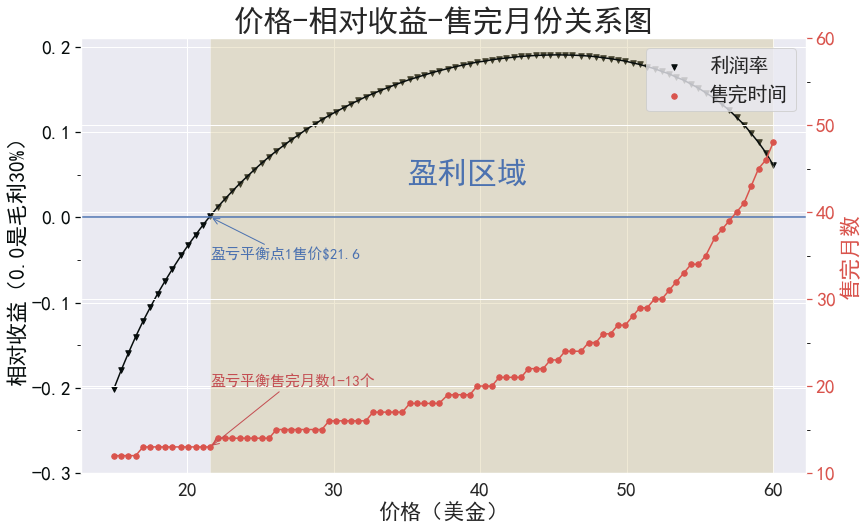

In [27]:
# 画布
fig=plt.figure(figsize=(13,8))

# 主坐标轴
ax=fig.add_subplot(1,1,1)
line1,=ax.plot(x,y1,color = sns.xkcd_rgb["almost black"],linestyle = '-',label='利润率')
p1 = ax.scatter(x, y1,color = sns.xkcd_rgb["almost black"],marker = 'v',s = 30,label = '利润率')
ax.set_xlabel('价格（美金）')
ax.set_ylabel("相对收益（0.0是毛利30%）")
ax.set_yticks(ticks=np.arange(-0.3, 0.1,0.05),minor=True)
# 坐标轴颜色
ax.yaxis.label.set_color(line1.get_color())
ax.tick_params(axis = 'y', colors = line1.get_color())

# 次坐标轴
ax2=ax.twinx()
line2,=ax2.plot(x,y2,color = sns.xkcd_rgb["pale red"],linestyle = '-',label='售完时间')
p2 = ax2.scatter(x, y2,color = sns.xkcd_rgb["pale red"],marker = 'o',s = 30,label = '售完时间')
ax2.set_ylabel('售完月数')
ax2.set_yticks(ticks=np.arange(10, 65,5),minor=True)
# 双Y轴标签颜色设置
ax2.yaxis.label.set_color(line2.get_color())
ax2.tick_params(axis = 'y', colors = line2.get_color())

# 添加其它信息
# 标题
ax.set_title('价格-相对收益-售完月份关系图',fontdict={'size':30})
# 图例
plt.legend(handles=[p1,p2])
# 画辅助线
ax.axhline(0,label='相对收益为0') 
# 盈利区间及说明
ax.axvspan(xmin=price_min,xmax=price_max,facecolor='y',alpha=0.3)
ax.text(35,0.04,'盈利区域',weight='bold',color='b',size=30)
# 添加注释及箭头
ax.annotate("盈亏平衡点1售价${}".format(price_min),xy=(price_min,0),xytext=(price_min,-0.05),weight='bold',color='b',arrowprops=dict(arrowstyle='->',connectionstyle='arc3',color='b'),fontsize=15)
ax2.annotate("盈亏平衡售完月数1-{}个".format(month_min),xy=(price_min,13),xytext=(price_min,20),weight='bold',color='r',arrowprops=dict(arrowstyle='->',connectionstyle='arc3',color='r'),fontsize=15)
# 展示
plt.show()
